# Task 3 - Modeling

**Problem Statement:**

>Can we accurately predict the stock levels of products, based on sales data and sensor data, on an hourly basis in order to more intelligently procure products from our suppliers.

## Importing Libraries

In [ ]:
!pip install pandas numpy matplotlib seaborn --quiet
!pip install scikit-learn xgboost --upgrade --quiet

In [ ]:
import os
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import joblib

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [ ]:
# setting the configuration for dataframe and visualization
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid')

## Downloading and Loading the Dataset

In [ ]:
# Creating a data directory
data_path = 'data'
if os.path.exists(data_path):
    print('[INFO] Data directory exists.')
else:
    print('[INF0] Creating data directory.')
    os.mkdir(data_path)

[INF0] Creating data directory.


In [ ]:
sales_url = 'https://cdn.theforage.com/vinternships/companyassets/e6nrxEAa6MHFh3Jmw/DCGoJxzfdJHirTYGe/1652212400513/sales.csv'
sales_path = os.path.join(data_path, 'sales.csv')
stock_url = 'https://cdn.theforage.com/vinternships/companyassets/e6nrxEAa6MHFh3Jmw/DCGoJxzfdJHirTYGe/1652212438184/sensor_stock_levels.csv'
stock_path = os.path.join(data_path, 'sensor_stock_levels.csv')
temp_url = 'https://cdn.theforage.com/vinternships/companyassets/e6nrxEAa6MHFh3Jmw/DCGoJxzfdJHirTYGe/1652212467098/sensor_storage_temperature.csv'
temp_path = os.path.join(data_path, 'sensor_storage_temperature.csv')

if os.path.exists(sales_path):
    print(f'[INFO] {sales_path} already exist.')
elif os.path.exists(stock_path):
    print(f'[INFO] {stock_path} already exist.')
elif os.path.exists(temp_path):
    print(f'[INFO] {temp_path} already exist.')
else:
    print('[INFO] Downloading the sales and sensor data file:\n')
    urlretrieve(sales_url, sales_path)
    print(f'{sales_path} downloaded.')
    urlretrieve(stock_url, stock_path)
    print(f'{stock_path} downloaded.')
    urlretrieve(temp_url, temp_path)
    print(f'{temp_path} downloaded.')    

[INFO] Downloading the sales and sensor data file:

data/sales.csv downloaded.
data/sensor_stock_levels.csv downloaded.
data/sensor_storage_temperature.csv downloaded.


In [ ]:
# Loading the sales data
sales_df = pd.read_csv(sales_path)
sales_df.drop(columns=['Unnamed: 0'], inplace=True)
sales_df

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:23:58,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:32:43,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card
...,...,...,...,...,...,...,...,...,...
7824,6c19b9fc-f86d-4526-9dfe-d8027a4d13ee,2022-03-03 18:22:09,bc6187a9-d508-482b-9ca6-590d1cc7524f,cleaning products,basic,14.19,2,28.38,e-wallet
7825,1c69824b-e399-4b79-a5e7-04a3a7db0681,2022-03-04 19:14:46,707e4237-191c-4cc9-85af-383a6c1cb2ab,cleaning products,standard,16.99,1,16.99,credit card
7826,79aee7d6-1405-4345-9a15-92541e9e1e74,2022-03-03 14:00:09,a9325c1a-2715-41df-b7f4-3078fa5ecd97,cleaning products,basic,14.19,2,28.38,credit card
7827,e5cc4f88-e5b7-4ad5-bc1b-12a828a14f55,2022-03-04 15:11:38,707e4237-191c-4cc9-85af-383a6c1cb2ab,cleaning products,basic,16.99,4,67.96,cash


In [ ]:
# Loading the sensor stock level data
stock_df = pd.read_csv(stock_path)
stock_df.drop(columns=['Unnamed: 0'], inplace=True)
stock_df

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:17:43,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:29:09,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:46:18,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22
...,...,...,...,...
14995,b9bf6788-09f3-490b-959b-dc5b55edb4b6,2022-03-04 10:52:50,e37658de-3649-4ddb-9c73-b868dd69d3fe,0.66
14996,9ff1cc01-020f-491a-bafd-13552dccff44,2022-03-02 12:25:48,fbeb39cc-8cd0-4143-bdfb-77658a02dec9,0.99
14997,4d8101de-e8a2-4af9-9764-7a3a22aa7084,2022-03-03 17:36:44,8e21dcec-d775-4969-8334-05a37a5fd189,0.72
14998,5f2a7b1e-b3c4-4395-8425-c960e22f701d,2022-03-02 19:42:47,9708cf5b-aa69-4320-a013-9d234c40e63f,0.95


In [ ]:
# Loading the sensor stock level data
temp_df = pd.read_csv(temp_path)
temp_df.drop(columns=['Unnamed: 0'], inplace=True)
temp_df

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:12:26,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:30:42,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:09:33,1.38
...,...,...,...
23885,17bcff56-9965-4e9f-ad5f-107f0f3be93f,2022-03-01 10:40:43,-1.46
23886,51d4eb44-04bd-4d6a-b777-0653bc173303,2022-03-05 17:07:49,-19.37
23887,bbcacfc4-3b59-47ee-b9e1-7dd3bd588748,2022-03-01 16:15:41,-2.89
23888,5c4d567b-4bcf-4fcd-86b7-e2db5de6e439,2022-03-07 14:44:52,-2.56


## Preprocessing and Feature Engineering

Checking info of all three dataset

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id           15000 non-null  object 
 3   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 468.9+ KB


In [ ]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           23890 non-null  object 
 1   timestamp    23890 non-null  object 
 2   temperature  23890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 560.0+ KB


In [ ]:
# Creating a helper function to display unique values
def get_unique_data(data: pd.DataFrame, col_name: str):
    unique_data = data[col_name].unique()
    unique_count = data[col_name].value_counts()
    print(f'Column Name: {col_name}, total data: {len(data[col_name])} contains total unique data: {len(unique_data)}\n')
    return unique_count

Checking if there are any duplicate values

In [ ]:
get_unique_data(sales_df, 'transaction_id')

Column Name: transaction_id, total data: 7829 contains total unique data: 7829



a1c82654-c52c-45b3-8ce8-4c2a1efe63ed    1
6532e258-95fd-4eb5-8c67-2bfb879a8fec    1
6fce2af3-47a0-4755-99c9-0cefb5ab6f41    1
6476e388-3990-471f-b415-3ee59ae18832    1
10afe89b-c45b-49a2-b0be-dec89a4c3f80    1
                                       ..
a9abe5ac-99d5-4d8b-bbbd-c2a207642849    1
6b0b23e8-412b-4665-8cc4-3e37f0d9e195    1
711a4162-1985-4f5a-94ca-137cfacaeadf    1
7d1e9010-dbaf-4770-a467-f31477910f7a    1
afd70b4f-ee21-402d-8d8f-0d9e13c2bea6    1
Name: transaction_id, Length: 7829, dtype: int64

In [ ]:
get_unique_data(stock_df, 'id')

Column Name: id, total data: 15000 contains total unique data: 15000



4220e505-c247-478d-9831-6b9f87a4488a    1
e11b6d61-7d32-46a7-b5a4-c77300033038    1
3817056c-433f-41c4-afdb-7075e45f9523    1
5e0098c4-c38e-4a0d-9781-cd231c19aad7    1
3a57f166-8810-428a-abe6-70e3acd5759e    1
                                       ..
65ad3067-f0c0-45ab-a184-0b39223ad622    1
429efc47-c31d-4893-8b11-18fb5a9d2735    1
ab3f42d4-78fd-41cf-8046-8d8c5ebe1cb4    1
488d278c-a570-4362-8cb6-7df4bfb5d48b    1
af6f4493-e49d-4dcb-951d-308e6cce267b    1
Name: id, Length: 15000, dtype: int64

In [ ]:
get_unique_data(temp_df, 'id')

Column Name: id, total data: 23890 contains total unique data: 23890



d1ca1ef8-0eac-42fc-af80-97106efc7b13    1
c686838c-d442-4cbd-ab0a-55f78fe9dcaf    1
0e9215cd-6ead-4aa5-97bb-482b3ada0fe9    1
446247d5-d2a3-4492-a611-f4b49e8cfac2    1
7d9c4918-41b3-472a-b1b3-126e827e8623    1
                                       ..
37831795-dd5b-4e71-9839-a39d2d898d39    1
f86aae7f-5865-4484-a6c2-856001b749e2    1
ca8da1dc-72e2-4b93-bfca-7842b8a2bf41    1
078611d1-50e4-42c1-9866-b0bffb05c218    1
589c28e1-f1f3-4efb-af6d-9f194c4d7d5b    1
Name: id, Length: 23890, dtype: int64

No duplicates are present in any of the dataset

### Type Conversion

Changing the datatype of the timestamp column

In [ ]:
# Creating a helper function for changing datatype
def convert_to_datetime(data: pd.DataFrame, col_name: str):
    data[col_name] = pd.to_datetime(data[col_name], format='%Y-%m-%d %H:%M:%S')
    data.info()

In [ ]:
convert_to_datetime(sales_df, 'timestamp')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  7829 non-null   object        
 1   timestamp       7829 non-null   datetime64[ns]
 2   product_id      7829 non-null   object        
 3   category        7829 non-null   object        
 4   customer_type   7829 non-null   object        
 5   unit_price      7829 non-null   float64       
 6   quantity        7829 non-null   int64         
 7   total           7829 non-null   float64       
 8   payment_type    7829 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 550.6+ KB


In [ ]:
convert_to_datetime(stock_df, 'timestamp')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   15000 non-null  object        
 1   timestamp            15000 non-null  datetime64[ns]
 2   product_id           15000 non-null  object        
 3   estimated_stock_pct  15000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 468.9+ KB


In [ ]:
convert_to_datetime(temp_df, 'timestamp')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           23890 non-null  object        
 1   timestamp    23890 non-null  datetime64[ns]
 2   temperature  23890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 560.0+ KB


All the timestamp is converted to datetime data type.

### Merging Datasets

Before merging the dataset, there is some feature engineering to be done with the timestamp.

If you remember the problem statement that was mentioned at the start of the , it is mentioned that the client needs the prediction of the stock on hourly basis.

So the focus will be on the product and timestamp feature.

First lets change the timestamp to hourly only.

In [ ]:
def replace_time(data: pd.DataFrame, col_name: str):
    data[col_name] = data[col_name].apply(lambda x: x.replace(minute=00, second=00))
    return data.head()

In [ ]:
replace_time(sales_df, 'timestamp')

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:00:00,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:00:00,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:00:00,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


In [ ]:
replace_time(stock_df, 'timestamp')

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:00:00,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:00:00,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:00:00,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:00:00,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79
4,08a32247-3f44-4002-85fb-c198434dd4bb,2022-03-02 13:00:00,7f478817-aa5b-44e9-9059-8045228c9eb0,0.22


In [ ]:
replace_time(temp_df, 'timestamp')

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:00:00,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:00:00,1.88
2,3d47a0c7-1e72-4512-812f-b6b5d8428cf3,2022-03-04 15:00:00,1.78
3,9500357b-ce15-424a-837a-7677b386f471,2022-03-02 12:00:00,2.18
4,c4b61fec-99c2-4c6d-8e5d-4edd8c9632fa,2022-03-05 09:00:00,1.38


I have converted our data on hourly basis, lets aggregate the values based on the product and timestamp.

For the sales dataframe, quantity feature will be aggregated.

In [ ]:
sales_agg = sales_df.groupby(by=['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
sales_agg

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11
...,...,...,...
6212,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,3
6213,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,3
6214,2022-03-07 19:00:00,f3bec808-bee0-4597-a129-53a3a2805a43,2
6215,2022-03-07 19:00:00,fd66ac0b-3498-4613-8ec0-764686b0d864,1


For the stock dataframe, estimated_stock_pct feature will be aggregated

In [ ]:
stock_agg = stock_df.groupby(by=['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
stock_agg

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05
...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92


For the temp dataframe, I will aggregate the temperature feature.

In [ ]:
temp_agg = temp_df.groupby(by=['timestamp']).agg({'temperature': 'mean'}).reset_index()
temp_agg.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.028850
1,2022-03-01 10:00:00,1.284314
2,2022-03-01 11:00:00,-0.560000
3,2022-03-01 12:00:00,-0.537721
4,2022-03-01 13:00:00,-0.188734


Now lets merge the dataframe, for the base dataframe lets use the stock dataframe and merge all the important features to it.

In [ ]:
merged_df = stock_agg.merge(sales_agg, on=['timestamp', 'product_id'], how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN


In [ ]:
merged_df = merged_df.merge(temp_agg, on=['timestamp'], how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.02885
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.02885
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.02885


Now that I have combined the aggregate data, I can also add the unit price and category feature in the merged dataframe.

Category and unit price are unique and are specific for certain products. If you have noticed both the data are in the sales dataframe which is based on the transactions done, this means that there will be duplicate values for same product id purchased.

Lets clean the data before merging it.

In [ ]:
# Getting unique values for product
get_unique_data(sales_df, 'product_id')

Column Name: product_id, total data: 7829 contains total unique data: 300



ecac012c-1dec-41d4-9ebd-56fb7166f6d9    114
80da8348-1707-403f-8be7-9e6deeccc883    109
0ddc2379-adba-4fb0-aa97-19fcafc738a1    108
7c55cbd4-f306-4c04-a030-628cbe7867c1    104
3bc6c1ea-0198-46de-9ffd-514ae3338713    101
                                       ... 
49f7d4a9-713a-4824-b378-aebb33ff8b2f      5
a8fab83a-16d4-4db0-a83a-f824ecd8604a      5
c8de27d0-2c44-4b5a-b178-59c45d054ccb      5
5adfc643-aa8e-4140-b2c3-98a946444632      5
ec0bb9b5-45e3-4de8-963d-e92aa91a201e      3
Name: product_id, Length: 300, dtype: int64

In [ ]:
product_df = sales_df.drop_duplicates(['product_id', 'category', 'unit_price']).loc[:,['product_id', 'category', 'unit_price']]
product_df

,product_id,category,unit_price
0,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,3.99
1,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,3.99
2,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,0.19
3,80da8348-1707-403f-8be7-9e6deeccc883,fruit,0.19
4,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,4.49
...,...,...,...
7569,d6ccd088-11be-4c25-aa1f-ea87c01a04db,cleaning products,14.99
7570,20a9bd7b-daff-4b8b-bdc1-2e8f9a0277fa,cleaning products,13.49
7572,a9325c1a-2715-41df-b7f4-3078fa5ecd97,cleaning products,14.19
7576,0e4c10f4-77bc-4c67-86b2-b4da5ded19bf,cleaning products,16.99


Merging the product data to the merged dataframe

In [ ]:
merged_df = merged_df.merge(product_df, on=['product_id'], how='left')
merged_df

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.028850,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.028850,vegetables,1.49
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.028850,baby products,14.19
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.028850,beverages,20.19
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.028850,pets,8.19
...,...,...,...,...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50,4.0,-0.165077,fruit,4.99
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26,NaN,-0.165077,meat,19.99
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0,-0.165077,packaged foods,6.99
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0,-0.165077,meat,14.99


Lets check the info of the merged data

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             3067 non-null   float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


so, quantity have missing values, this missing values are present becuase there are no quantity for that certain time.

I can expect that the values will be 0 in this case.

In [ ]:
merged_df['quantity'] = merged_df['quantity'].fillna(0)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


### Feature Engineering - Timestamp

The current format of our timestamp is in DateTime format, which is not fit for modeling.

I will extract different features in number format and this will help durning the modeling.

In [ ]:
merged_df['timestamp_day'] = merged_df.timestamp.dt.day
merged_df['timestamp_day_of_week'] = merged_df.timestamp.dt.day_of_week
merged_df['timestamp_hour'] = merged_df.timestamp.dt.hour
merged_df

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,timestamp_day,timestamp_day_of_week,timestamp_hour
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.028850,kitchen,11.19,1,1,9
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.028850,vegetables,1.49,1,1,9
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.028850,baby products,14.19,1,1,9
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.028850,beverages,20.19,1,1,9
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.028850,pets,8.19,1,1,9
...,...,...,...,...,...,...,...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50,4.0,-0.165077,fruit,4.99,7,0,19
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26,0.0,-0.165077,meat,19.99,7,0,19
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0,-0.165077,packaged foods,6.99,7,0,19
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0,-0.165077,meat,14.99,7,0,19


### Selecting Features

Lets select the columns for the training

In [ ]:
merged_df.columns

Index(['timestamp', 'product_id', 'estimated_stock_pct', 'quantity',
       'temperature', 'category', 'unit_price', 'timestamp_day',
       'timestamp_day_of_week', 'timestamp_hour'],
      dtype='object')

In [ ]:
inputs_cols = merged_df.columns[3:].tolist()
target_col = merged_df.columns[2]
inputs_cols, target_col

(['quantity',
  'temperature',
  'category',
  'unit_price',
  'timestamp_day',
  'timestamp_day_of_week',
  'timestamp_hour'],
 'estimated_stock_pct')

In [ ]:
inputs_df = merged_df[inputs_cols].copy()
target = merged_df[target_col].copy()

In [ ]:
inputs_df.head()

,quantity,temperature,category,unit_price,timestamp_day,timestamp_day_of_week,timestamp_hour
0,3.0,-0.02885,kitchen,11.19,1,1,9
1,3.0,-0.02885,vegetables,1.49,1,1,9
2,0.0,-0.02885,baby products,14.19,1,1,9
3,0.0,-0.02885,beverages,20.19,1,1,9
4,0.0,-0.02885,pets,8.19,1,1,9


In [ ]:
target.head()

0    0.89
1    0.14
2    0.67
3    0.82
4    0.05
Name: estimated_stock_pct, dtype: float64

Now lets select numeric and categorical columns

In [ ]:
numeric_cols = merged_df[inputs_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = merged_df[inputs_cols].select_dtypes(include='object').columns.tolist()
numeric_cols, categorical_cols

(['quantity',
  'temperature',
  'unit_price',
  'timestamp_day',
  'timestamp_day_of_week',
  'timestamp_hour'],
 ['category'])

### Scaling Features

Normalizing the numeric features to a Min Max scaling level.

In [ ]:
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])
inputs_df

,quantity,temperature,category,unit_price,timestamp_day,timestamp_day_of_week,timestamp_hour
0,0.200000,0.553855,kitchen,0.462185,0.0,0.166667,0.0
1,0.200000,0.553855,vegetables,0.054622,0.0,0.166667,0.0
2,0.000000,0.553855,baby products,0.588235,0.0,0.166667,0.0
3,0.000000,0.553855,beverages,0.840336,0.0,0.166667,0.0
4,0.000000,0.553855,pets,0.336134,0.0,0.166667,0.0
...,...,...,...,...,...,...,...
10840,0.266667,0.512363,fruit,0.201681,1.0,0.000000,1.0
10841,0.000000,0.512363,meat,0.831933,1.0,0.000000,1.0
10842,0.200000,0.512363,packaged foods,0.285714,1.0,0.000000,1.0
10843,0.200000,0.512363,meat,0.621849,1.0,0.000000,1.0


In [ ]:
inputs_df.describe().loc[['min', 'max']]

,quantity,temperature,unit_price,timestamp_day,timestamp_day_of_week,timestamp_hour
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


### Encoding Features

Encoding the categorical feature using One Hot Encoding technique.

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [ ]:
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
inputs_df

,quantity,temperature,category,unit_price,timestamp_day,timestamp_day_of_week,timestamp_hour,category_baby products,category_baked goods,category_baking,category_beverages,category_canned foods,category_cheese,category_cleaning products,category_condiments and sauces,category_dairy,category_frozen,category_fruit,category_kitchen,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,0.200000,0.553855,kitchen,0.462185,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200000,0.553855,vegetables,0.054622,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.553855,baby products,0.588235,0.0,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.553855,beverages,0.840336,0.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.553855,pets,0.336134,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,0.266667,0.512363,fruit,0.201681,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10841,0.000000,0.512363,meat,0.831933,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10842,0.200000,0.512363,packaged foods,0.285714,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10843,0.200000,0.512363,meat,0.621849,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and Test Splits

Spliting the inputs dataframe and target series into training and testing split for modeling.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs_df[numeric_cols + encoded_cols], 
                                                    target, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
len(X_train), len(y_train)

(8133, 8133)

In [ ]:
len(X_test), len(y_test)

(2712, 2712)

## Modeling

Now, that I have prepared the features and splited the dataset, lets train the datsets on different models.

### Random Forest Regressor

The first model I will train is the Random Forest Regressor, this model will be our baseline model and check how our dataset will perform on this model.

In [ ]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
rf_model_train_pred = rf_model.predict(X_train)
rf_model_train_pred

array([0.52893333, 0.71134167, 0.48511667, ..., 0.71085   , 0.83367778,
       0.32225   ])

In [ ]:
rf_model_train_rmse = mean_squared_error(y_train, rf_model_train_pred, squared=False)
rf_model_train_rmse

0.11500351992028916

In [ ]:
rf_model_train_mae = mean_absolute_error(y_train, rf_model_train_pred)
rf_model_train_mae

0.09271266518911163

In [ ]:
rf_model_test_pred = rf_model.predict(X_test)
rf_model_test_pred

array([0.47419917, 0.3983    , 0.3793125 , ..., 0.42377083, 0.67236667,
       0.483275  ])

In [ ]:
rf_model_test_rmse = mean_squared_error(y_test, rf_model_test_pred, squared=False)
rf_model_test_rmse

0.2837404211501784

In [ ]:
rf_model_test_mae = mean_absolute_error(y_test, rf_model_test_pred)
rf_model_test_mae

0.23627168753258992

Looking at the model's feature importance

In [ ]:
rf_model_importance = pd.DataFrame({'feature': X_train.columns,
                                    'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)

Text(0.5, 1.0, 'Random Forest Model Feature Importance')

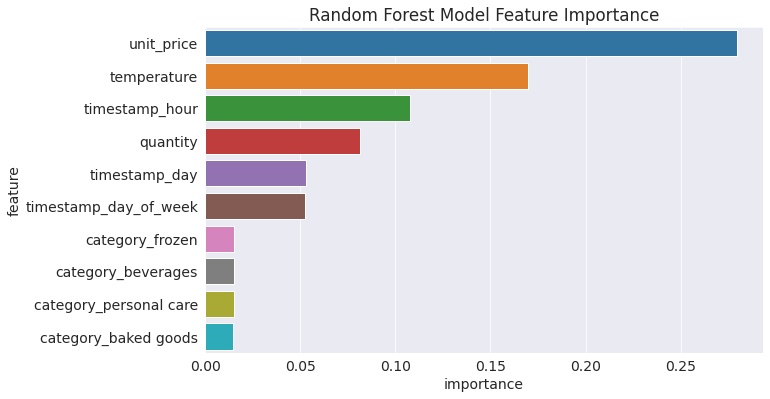

In [ ]:
sns.barplot(data=rf_model_importance[:10], x='importance', y='feature')
plt.title('Random Forest Model Feature Importance')

Storing the evaluated result in a dataframe

In [ ]:
model_result_df = pd.DataFrame({'model': [str(rf_model)], 
                                'train_rmse': [rf_model_train_rmse],
                                'test_rmse': [rf_model_test_rmse],
                                'train_mae': [rf_model_train_mae],
                                'test_mae': [rf_model_test_mae]})
model_result_df

,model,train_rmse,test_rmse,train_mae,test_mae
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",0.115004,0.28374,0.092713,0.236272


### Random Forest - Hyperparameter Tuning

I will be tuning the following parameters using the RandomizedSearchCV:

1. n_estimators
2. max_depth
3. max_features
4. max_samples

Creating a helper function for evaluation metrics

In [ ]:
def rmse_mae_loss(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

Creating a helper function for training the model using hyperparameters.

In [ ]:
def train_eval_model(model, X_train, y_train, X_test, y_test, **params):
    model = model(random_state=42, **params)
    model.fit(X_train, y_train)
    train_rmse, train_mae = rmse_mae_loss(y_train, model.predict(X_train))
    test_rmse, test_mae = rmse_mae_loss(y_test, model.predict(X_test))
    print(f'RMSE Result: Train: {train_rmse}, Test: {test_rmse}')
    print(f'MAE Result: Train: {train_mae}, Test: {test_mae}\n')
    return model, train_rmse, test_rmse, train_mae, test_mae

In [ ]:
x = train_eval_model(RandomForestRegressor, X_train, y_train, X_test, y_test, n_jobs=-1)

RMSE Result: Train: 0.11500351992028916, Test: 0.2837404211501784
MAE Result: Train: 0.09271266518911163, Test: 0.23627168753258992



In [ ]:
rf_param_grid = {'n_estimators': np.arange(50, 400, 50),
                 'max_depth': [3, 5, 7, 9],
                 'max_features': np.arange(0.1, 1.1, 0.1),
                 'max_samples': np.arange(0.1, 1.1, 0.1)}

random_search = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                                   rf_param_grid,
                                   n_iter=70,
                                   n_jobs=-1).fit(X_train, y_train)
random_search.best_estimator_

RandomForestRegressor(max_depth=3, max_features=0.1, max_samples=0.9,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(RandomForestRegressor,  
                                                                     X_train, 
                                                                     y_train, 
                                                                     X_test, 
                                                                     y_test,
                                                                     n_jobs=-1, 
                                                                     max_depth=3, 
                                                                     max_features=0.1, 
                                                                     max_samples=0.9,
                                                                     n_estimators=300)

RMSE Result: Train: 0.2643277430217721, Test: 0.26348404365690353
MAE Result: Train: 0.22224860918403974, Test: 0.22195824694172728



Models performance is improved with the help of RandomizedSearchCV, previously the model was overfitting after using the suggested huperparameters the model is not overfitting and improved the loss for the test dataset.

Checking the feature importance

In [ ]:
model_importance = pd.DataFrame({'feature': X_train.columns,
                                 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

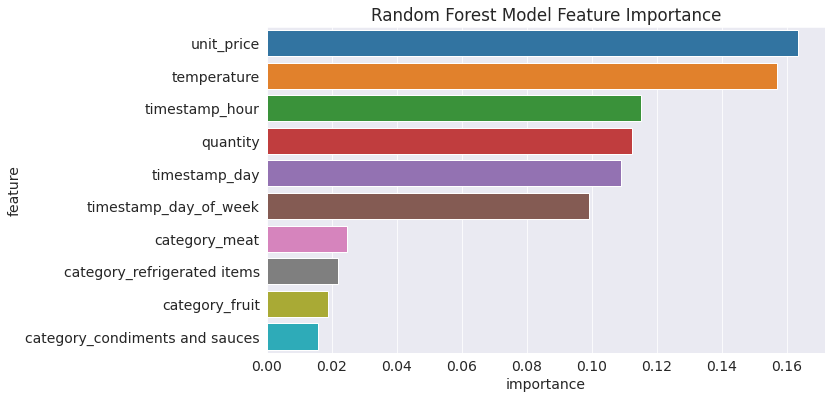

In [ ]:
sns.barplot(data=model_importance.iloc[:10], x='importance', y='feature')
plt.title('Random Forest Model Feature Importance');

Saving the model result

In [ ]:
model_result_df.loc[len(model_result_df)] = [str(model), train_rmse, test_rmse, train_mae, test_mae]
model_result_df

,model,train_rmse,test_rmse,train_mae,test_mae
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",0.115004,0.283740,0.092713,0.236272
1,"RandomForestRegressor(max_depth=3, max_feature...",0.264328,0.263484,0.222249,0.221958


### Gradient Boosting Regressor

In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(GradientBoostingRegressor,  X_train, y_train, X_test, y_test)

RMSE Result: Train: 0.25929419177853763, Test: 0.2646393966694013
MAE Result: Train: 0.21762981305083984, Test: 0.2228078913472723



In [ ]:
model_importance = pd.DataFrame({'feature': X_train.columns,
                                 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

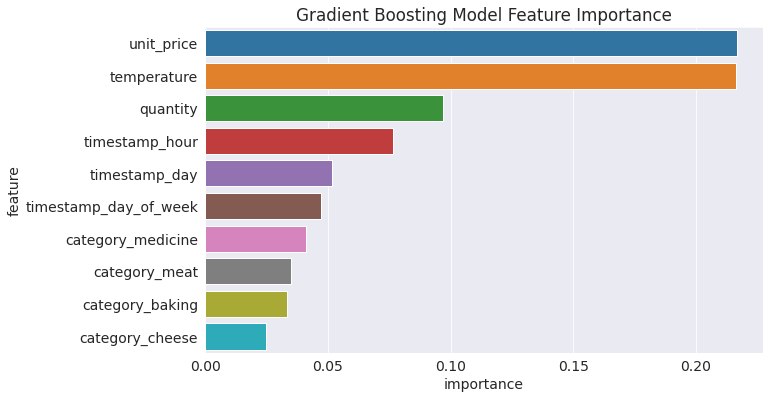

In [ ]:
sns.barplot(data=model_importance.iloc[:10], x='importance', y='feature')
plt.title('Gradient Boosting Model Feature Importance');

In [ ]:
model_result_df.loc[len(model_result_df)] = [str(model), train_rmse, test_rmse, train_mae, test_mae]
model_result_df

,model,train_rmse,test_rmse,train_mae,test_mae
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",0.115004,0.283740,0.092713,0.236272
1,"RandomForestRegressor(max_depth=3, max_feature...",0.264328,0.263484,0.222249,0.221958
2,GradientBoostingRegressor(random_state=42),0.259294,0.264639,0.217630,0.222808


### Gradient Boosting Regressor - Hyperparameter Tuning

Using the RandomizedSearchCV with the following parameters:

1. learning_rate
2. n_estimators
3. max_depth
4. max_features

In [ ]:
gb_param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.9, 0.99],
                 'n_estimators': np.arange(50, 400, 50),
                 'max_depth': np.arange(2, 10, 2),
                 'max_features': np.arange(0.1, 1.1, 0.1)}

random_search = RandomizedSearchCV(GradientBoostingRegressor(random_state=42),
                                   gb_param_grid,
                                   n_iter=70,
                                   n_jobs=-1).fit(X_train, y_train)
random_search.best_estimator_

GradientBoostingRegressor(learning_rate=0.001, max_depth=2, max_features=0.1,
                          n_estimators=50, random_state=42)

In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(GradientBoostingRegressor,  
                                                                     X_train, 
                                                                     y_train, 
                                                                     X_test, 
                                                                     y_test,
                                                                     learning_rate=0.001, 
                                                                     max_depth=4,
                                                                     max_features=0.1)

RMSE Result: Train: 0.26472991665778495, Test: 0.26350756904636663
MAE Result: Train: 0.2225912691035971, Test: 0.2219744081167812



In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(GradientBoostingRegressor,  
                                                                     X_train, 
                                                                     y_train, 
                                                                     X_test, 
                                                                     y_test,
                                                                     learning_rate=0.0001, 
                                                                     max_depth=2,
                                                                     max_features=0.6, 
                                                                     n_estimators=150)

RMSE Result: Train: 0.2648361103378913, Test: 0.26350851300740263
MAE Result: Train: 0.22267771057896824, Test: 0.22197685313802687



In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(GradientBoostingRegressor,  
                                                                     X_train, 
                                                                     y_train, 
                                                                     X_test, 
                                                                     y_test,
                                                                     learning_rate=0.001, 
                                                                     max_depth=7,
                                                                     max_features=0.1, 
                                                                     n_estimators=150)

RMSE Result: Train: 0.2639413694858207, Test: 0.2634880915785354
MAE Result: Train: 0.22194031179507473, Test: 0.22194613525219142



In [ ]:
model_importance = pd.DataFrame({'feature': X_train.columns,
                                 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

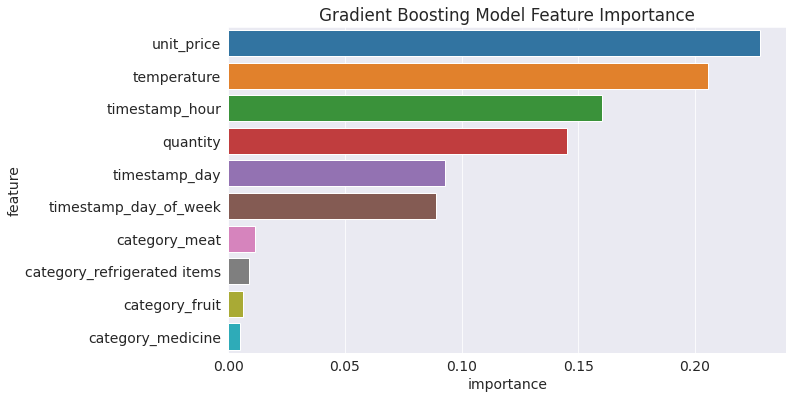

In [ ]:
sns.barplot(data=model_importance.iloc[:10], x='importance', y='feature')
plt.title('Gradient Boosting Model Feature Importance');

In [ ]:
model_result_df.loc[len(model_result_df)] = [str(model), train_rmse, test_rmse, train_mae, test_mae]
model_result_df

,model,train_rmse,test_rmse,train_mae,test_mae
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",0.115004,0.283740,0.092713,0.236272
1,"RandomForestRegressor(max_depth=3, max_feature...",0.264328,0.263484,0.222249,0.221958
2,GradientBoostingRegressor(random_state=42),0.259294,0.264639,0.217630,0.222808
3,"GradientBoostingRegressor(learning_rate=0.001,...",0.263941,0.263488,0.221940,0.221946


Gradient Boosting has shown similar results but with much better improvement on overfitting.

### XGBRegressor

In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(XGBRegressor, X_train, y_train, X_test, y_test, n_jobs=-1)

RMSE Result: Train: 0.1986268721950438, Test: 0.28298662642917943
MAE Result: Train: 0.16141165469812346, Test: 0.2356179641705728



In [ ]:
model_importance = pd.DataFrame({'feature': X_train.columns,
                                 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

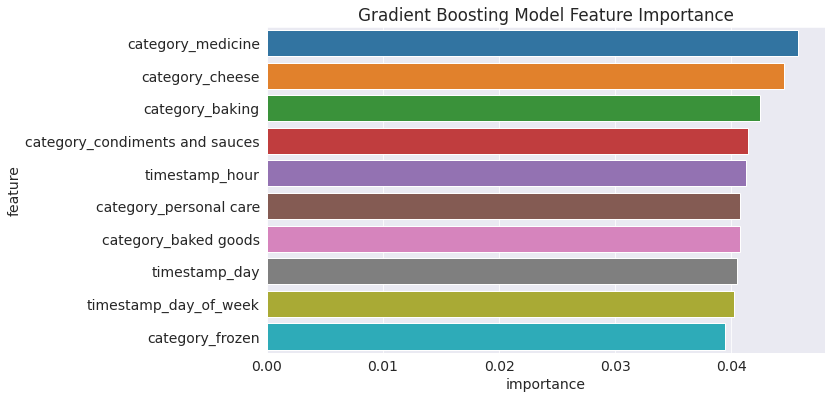

In [ ]:
sns.barplot(data=model_importance.iloc[:10], x='importance', y='feature')
plt.title('Gradient Boosting Model Feature Importance');

In [ ]:
model_result_df.loc[len(model_result_df)] = [str(model), train_rmse, test_rmse, train_mae, test_mae]
model_result_df

,model,train_rmse,test_rmse,train_mae,test_mae
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",0.115004,0.283740,0.092713,0.236272
1,"RandomForestRegressor(max_depth=3, max_feature...",0.264328,0.263484,0.222249,0.221958
2,GradientBoostingRegressor(random_state=42),0.259294,0.264639,0.217630,0.222808
3,"GradientBoostingRegressor(learning_rate=0.001,...",0.263941,0.263488,0.221940,0.221946
4,"XGBRegressor(base_score=None, booster=None, ca...",0.198627,0.282987,0.161412,0.235618


### XGBRegressor - Hyperparameters Tuning



In [ ]:
xgb_param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3],
                  'n_estimators': np.arange(100, 300, 50),
                  'max_depth': np.arange(2, 20, 3),
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}

random_search = RandomizedSearchCV(XGBRegressor(n_jobs=-1, random_state=42),
                                   xgb_param_grid,
                                   n_iter=70,
                                   n_jobs=-1).fit(X_train, y_train)
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.4, colsample_bynode=None, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
random_search.best_params_

{'subsample': 0.6,
 'n_estimators': 150,
 'max_depth': 2,
 'learning_rate': 0.0001,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.4}

In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(XGBRegressor,  
                                                                     X_train, 
                                                                     y_train, 
                                                                     X_test, 
                                                                     y_test,
                                                                     n_jobs=-1,
                                                                     colsample_bylevel=0.8,
                                                                     colsample_bytree=0.6,
                                                                     learning_rate=0.0001, 
                                                                     max_depth=2,
                                                                     n_estimators=150,
                                                                     subsample=0.5)

RMSE Result: Train: 0.26486413284866517, Test: 0.2636070276445933
MAE Result: Train: 0.22263767579777466, Test: 0.22199274065609995



In [ ]:
model_importance = pd.DataFrame({'feature': X_train.columns,
                                 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

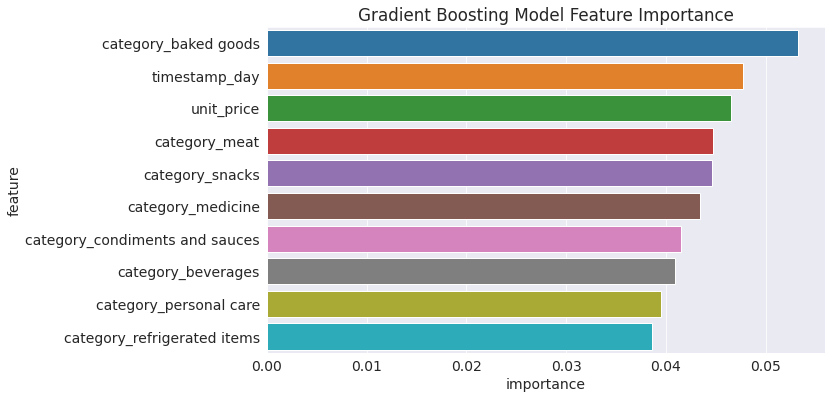

In [ ]:
sns.barplot(data=model_importance.iloc[:10], x='importance', y='feature')
plt.title('Gradient Boosting Model Feature Importance');

In [ ]:
model_result_df.loc[len(model_result_df)] = [str(model), train_rmse, test_rmse, train_mae, test_mae]
model_result_df

,model,train_rmse,test_rmse,train_mae,test_mae
0,"RandomForestRegressor(n_jobs=-1, random_state=42)",0.115004,0.283740,0.092713,0.236272
1,"RandomForestRegressor(max_depth=3, max_feature...",0.264328,0.263484,0.222249,0.221958
2,GradientBoostingRegressor(random_state=42),0.259294,0.264639,0.217630,0.222808
3,"GradientBoostingRegressor(learning_rate=0.001,...",0.263941,0.263488,0.221940,0.221946
4,"XGBRegressor(base_score=None, booster=None, ca...",0.198627,0.282987,0.161412,0.235618
5,"XGBRegressor(base_score=None, booster=None, ca...",0.264864,0.263607,0.222638,0.221993


After tuning XGBoost model has shown similar result as the other two models, but has underperformed compare to the gradient boosting model.

## Saving the Best Model

In [ ]:
model, train_rmse, test_rmse, train_mae, test_mae = train_eval_model(GradientBoostingRegressor,  
                                                                     X_train, 
                                                                     y_train, 
                                                                     X_test, 
                                                                     y_test,
                                                                     learning_rate=0.001, 
                                                                     max_depth=7,
                                                                     max_features=0.1, 
                                                                     n_estimators=150)

RMSE Result: Train: 0.2639413694858207, Test: 0.2634880915785354
MAE Result: Train: 0.22194031179507473, Test: 0.22194613525219142



In [ ]:
# Creating a dictionary containing all the objects
pkg_dict = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'inputs_cols': inputs_cols,
    'target_col': target_col,
    'encoded_cols': encoded_cols,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols
}

# Saving the objects in a joblib file
joblib.dump(pkg_dict, 'model_pkg.joblib')

['model_pkg.joblib']

## Conclusion

After initiating and creating different model experiment, the model that has minimized the overfitting problem and have got a good result is gradient boosting with a test result score of RMSE: 0.263488 and MAE: 0.221946.

The model gives a feature importance score which indicates that the feature unit price and temperature have the highest score following them quantity and timestamp feature have a good importance score.

Rest of the features are category which are one hot encoded, this features have the least importance score by the model.

